In [74]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pickle # for hacky deep copy
import random
from numpy import genfromtxt

# Project introduction:
## 1. Environment: a maze
A simple maze with 10x10 cells in default setting (scalable), with some cells are "Wall". The wall was put manually at first for testing. After that, I intened to make a function to generate wall randomly. However, to change the walls randomly, I need another algorithm to make sure the maze is solvable (randomized walls can some time blocks the door). Therefore, in this maze, the wall was manually put by hand in the way that guarantee the maze is always solvable.
    
    
The **agent** start at "start_position", which is random generated. First, the agent need to move to get the "key", which is also random generated, then, with the key in hand, finally the agent can exit the maze by going to the "door", which is also random generated.
    
    
The agent has four posibile **action**, going UP, DOWN, LEFT, RIGHT. If the agent want to move to the wall, or to the border of the maze, the agent return to its previous position.

## 3.  Algorithm: Sarsa with binary features and Linear Function Approximation
### 3.3 Method

In this file, I use the same Sarsa with binary features and LFA in the previous file. However, I use 800 featutes to represent all posible states, actions, and key possesion.

I also use random function to randomize the position of start, key and door    

In [75]:
RANDOM = True #Train = True also mean random
rows_count = 10
columns_count = 10

#step size for gradient descent
alpha = 0.2

#discount factor
gamma = 0.99

episode = 250 #episode to train. Need to change this to higher if the maze size is bigger than 10x10
maxStep = 300 #Maximum steps in 1 episode. Need to change this to higher if the maze size is bigger than 10x10
epsilon = 0.4 #doesn't need to change it here, since epsilon change itself base on episode

if (RANDOM):
    start_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
    
    terminating = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]    
    while(terminating==start_position):
        terminating = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
        
    key_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
    while((key_position==terminating)or(key_position==start_position)):
        key_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]        

else:
    start_position = [(0,0)]
    terminating = [(9,9)]
    key_position = [(0,8)]                        
                         
                        
DOOR = "D"
START = "S"
EMPTY = "E"
WALL = "W"
KEY = "K"
PATH = "P"
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
stepcost = -1
ACTION_LIST = ["UP", "DOWN", "LEFT", "RIGHT"]

def generateTestMaze():
    V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    V.fillna(EMPTY, inplace=True)
    V.iloc[0][1] = WALL
    V.iloc[1][1] = WALL
    V.iloc[2][1] = WALL
    
    V.iloc[1][3] = WALL
    V.iloc[1][5] = WALL
    V.iloc[1][6] = WALL
    
    V.iloc[4][0] = WALL
    V.iloc[4][1] = WALL
    V.iloc[4][2] = WALL
    V.iloc[4][3] = WALL    
    V.iloc[4][5] = WALL
    V.iloc[4][6] = WALL
    V.iloc[4][7] = WALL
    V.iloc[4][8] = WALL
    
    V.iloc[5][5] = WALL                
    V.iloc[5][8] = WALL
    
    V.iloc[6][1] = WALL
    V.iloc[6][2] = WALL
    V.iloc[7][2] = WALL
    V.iloc[8][2] = WALL
    V.iloc[9][2] = WALL
    V.iloc[6][7] = WALL
   
    
    V.iloc[7][4] = WALL
    V.iloc[7][5] = WALL
    V.iloc[7][6] = WALL
    
    V.iloc[8][8] = WALL
    V.iloc[9][8] = WALL
    
    V.iloc[0][7] = WALL
    V.iloc[1][7] = WALL
    V.iloc[2][7] = WALL    
    
    V.iloc[key_position[0][0]][key_position[0][1]] = KEY
    V.iloc[terminating[0][0]][terminating[0][1]] = DOOR
    V.iloc[start_position[0][0]][start_position[0][1]] = START
    return V
    

maze = generateTestMaze()
print(maze)

   0  1  2  3  4  5  6  7  8  9
0  E  W  E  E  E  E  E  W  E  E
1  E  W  D  W  E  W  W  W  E  E
2  E  W  E  E  E  E  E  W  E  E
3  E  E  E  E  E  E  E  E  E  E
4  W  W  W  W  E  W  W  W  K  E
5  E  E  E  E  E  W  E  E  W  E
6  S  W  W  E  E  E  E  W  E  E
7  E  E  W  E  W  W  W  E  E  E
8  E  E  W  E  E  E  E  E  W  E
9  E  E  W  E  E  E  E  E  W  E


(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

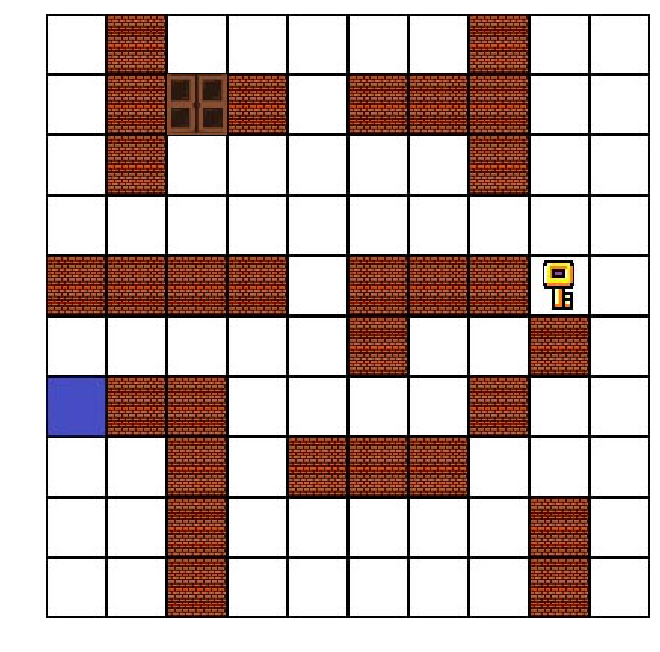

In [76]:
def arrayToImage(array, ncols=10):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


def makeImageArray(start, dataframe):
    imageArray = np.array([np.asarray(Image.open('images/empty.jpg').convert('RGB'))])
    for i in range(rows_count):
        for j in range(columns_count):
            #skip the first cell, since we already add it in the begining
            if (i!=0) or (j!=0):                
                path = "images/empty.jpg"
                if dataframe.iloc()[i][j] == WALL:
                    path = "images/wall.jpg"
                elif dataframe.iloc()[i][j] == DOOR:
                    path = "images/door.jpg"
                elif dataframe.iloc()[i][j] == PATH:
                    path = "images/path.jpg"
                elif dataframe.iloc()[i][j] == KEY:
                    path = "images/key.jpg"
                imageArray = np.append(imageArray, [np.asarray(Image.open(path).convert('RGB'))], axis=0)  
    
    path = "images/path.jpg"
    imageArray[start[0][0]*rows_count+start[0][1]] = np.asarray(Image.open(path).convert('RGB'))
    return imageArray

def showMaze(array):
    print(array.shape)
    result = arrayToImage(array)
    plt.figure(2)
    fig=plt.figure(figsize=(8, 8), dpi = 100)
    plt.imshow(result)
    plt.axis('off')    
    plt.show()        

array = makeImageArray(start_position, maze)
showMaze(array)

<Figure size 432x288 with 0 Axes>

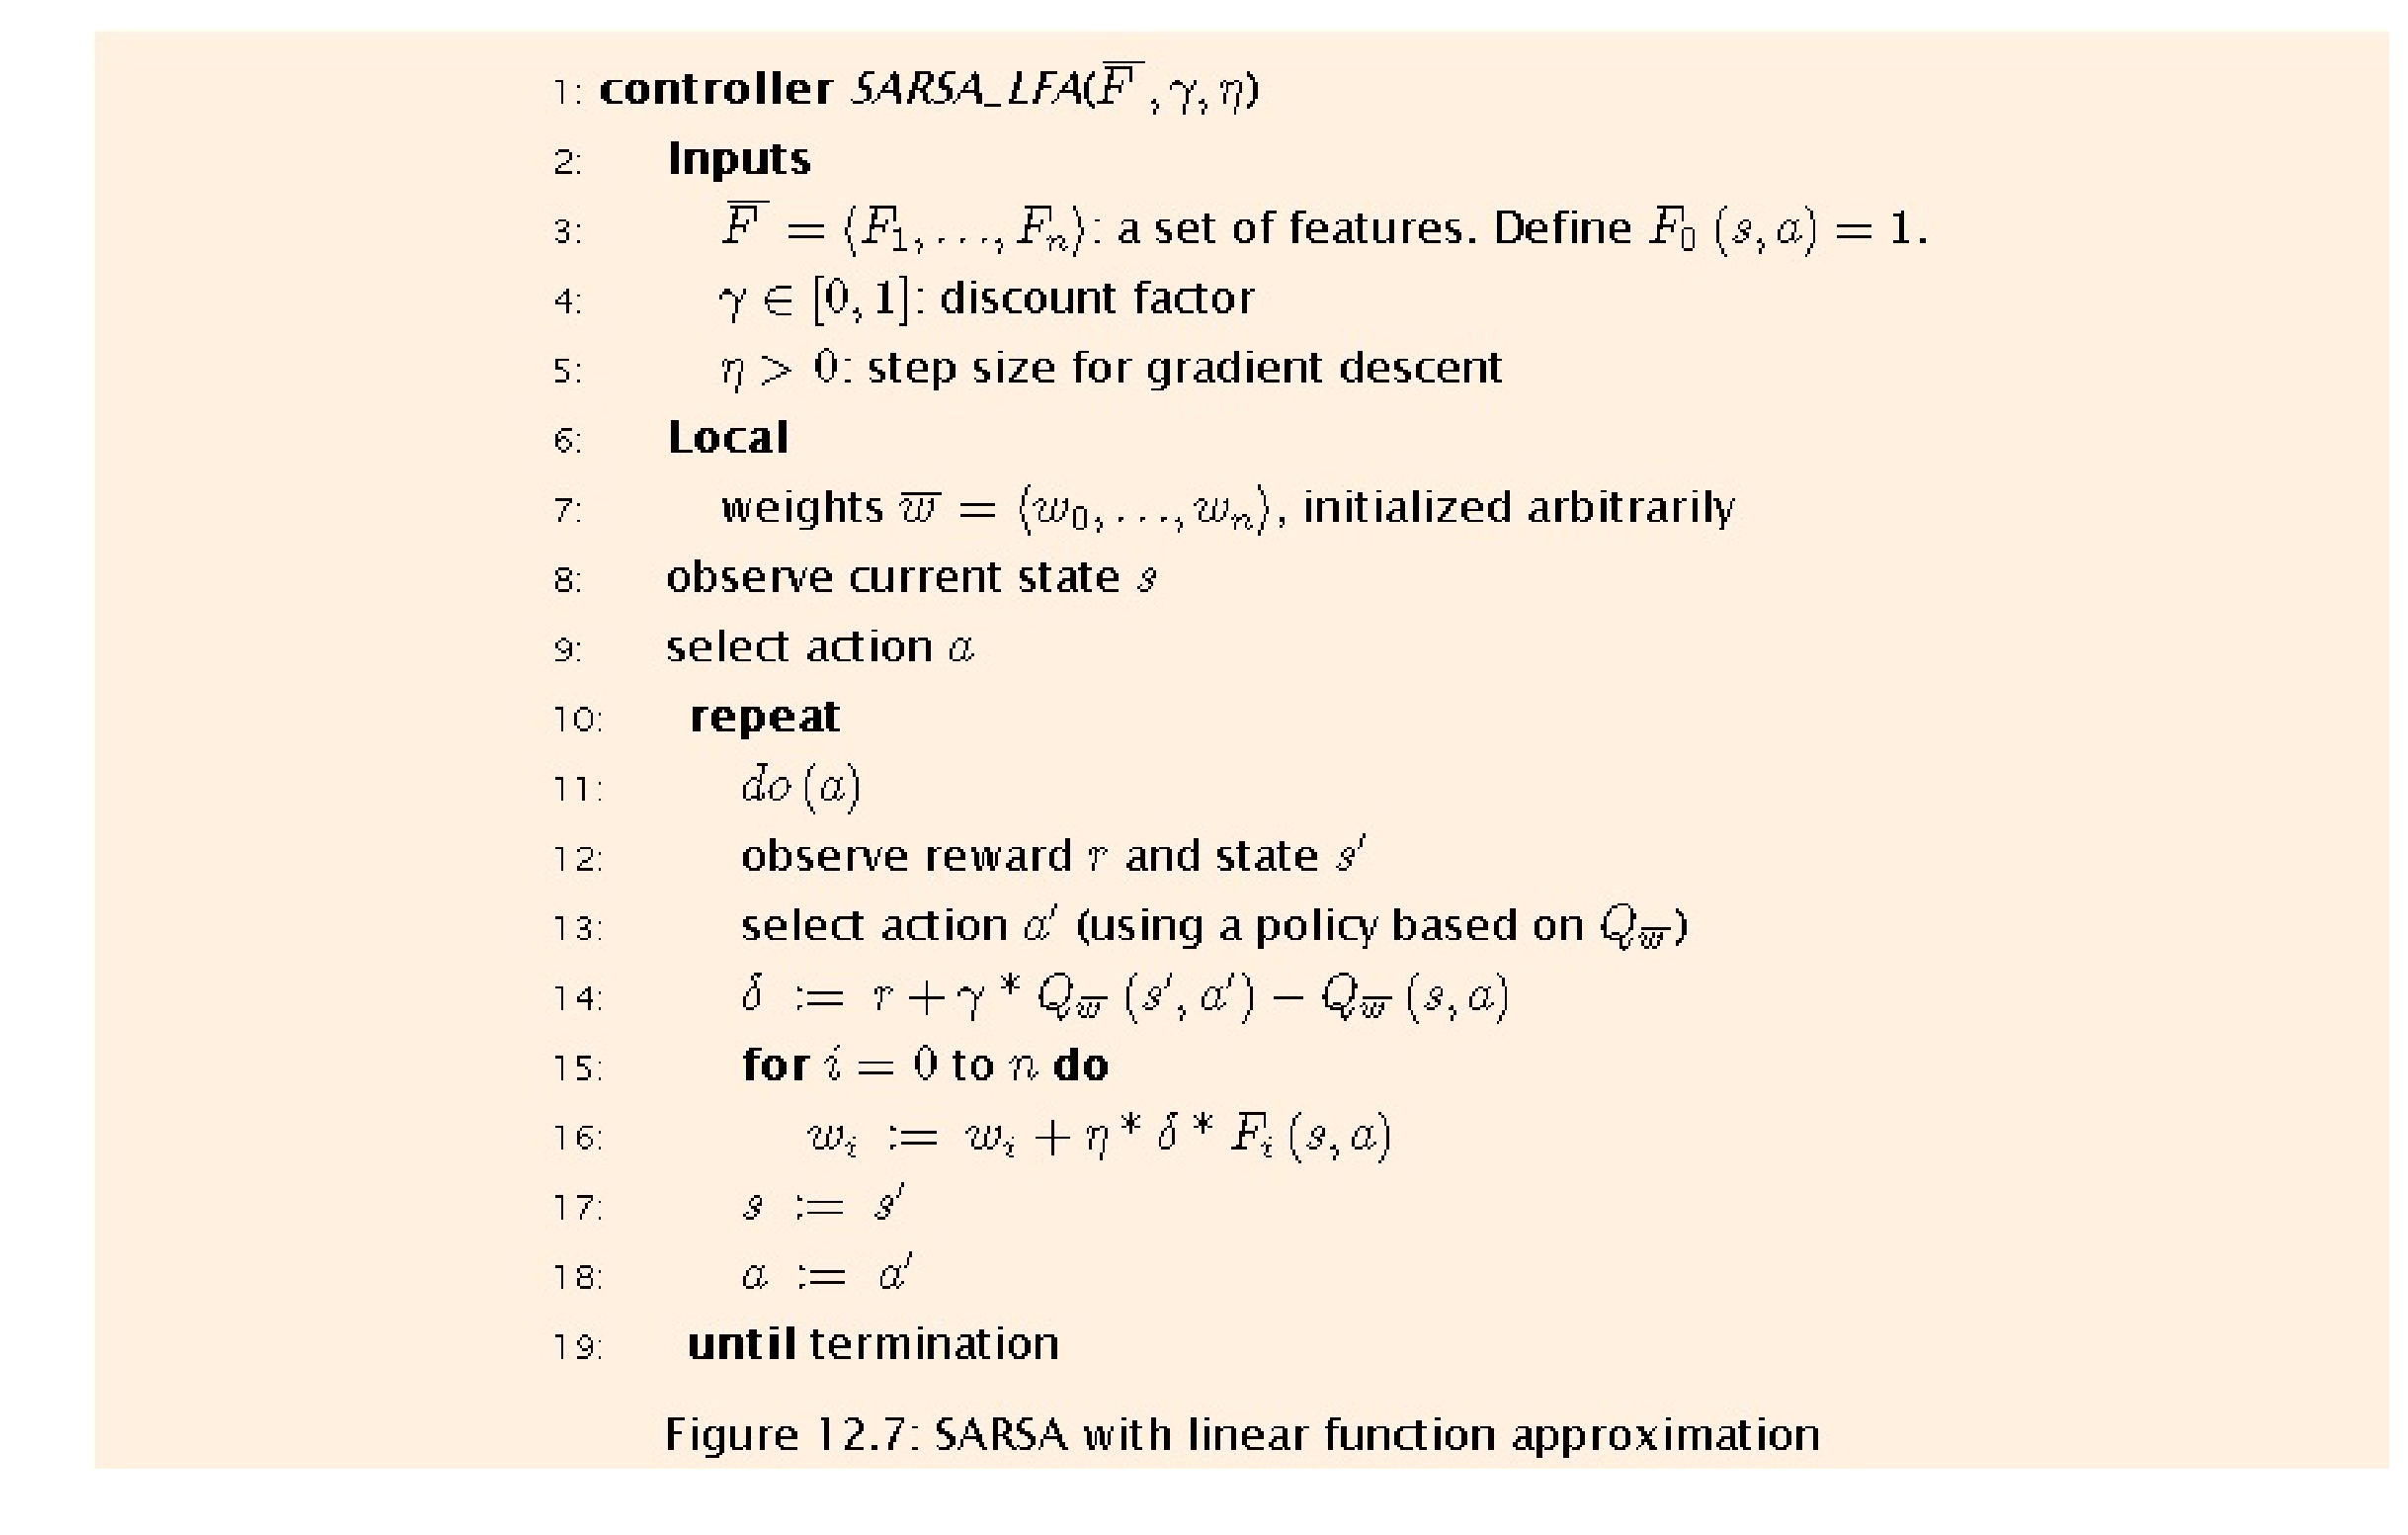

In [77]:
#Formular print
#from: https://artint.info/2e/html/ArtInt2e.Ch12.S9.SS1.html
image = Image.open('sarsaLFA_pseudo.jpg')
plt.figure(2)
fig=plt.figure(figsize=(15, 15), dpi = 200)
plt.imshow(image)
plt.axis('off')
plt.show()

In [78]:
def isWall(row, column, action, baseMaze):
    """
    Return True if action hit the Wall (or boundaries) of the maze
    """
    hitWall = False
    if (action == UP):
        actionRow = row-1
        actionColumn = column
    elif (action == DOWN) :
        actionRow = row+1
        actionColumn = column
    elif (action == LEFT) :
        actionRow = row
        actionColumn = column-1
    elif (action == RIGHT) :
        actionRow = row
        actionColumn = column+1
        
    if (actionRow not in range(rows_count)) or (actionColumn not in range(columns_count)):
        hitWall = True
        
    if (not hitWall):
        if (maze.iloc()[actionRow][actionColumn]) == "W":
            hitWall = True
    return hitWall

def validMoves(row, column, action):    
    """
    :param row
    :param column
    :param action
    
    Make sure that the action don't make you step out of the array bondary [0, rows_count-1] or [0, columns_count-1]
    Some codes look like it doesn't do anything (actionColumn = max(column, 0)), but it actually does something
    in other scenario (column was change because of "Wind blow left", so just leave it there)
    """
    
    if (action == UP):
        actionRow = max(min(row-1, rows_count-1), 0)
        actionColumn = max(min(column, columns_count-1),0)
    elif (action == DOWN) :
        actionRow = max(min(row+1, rows_count-1),0)
        actionColumn = max(min(column, columns_count-1),0)
    elif (action == LEFT) :
        actionRow = max(min(row, rows_count-1),0)
        actionColumn = max(column-1, 0)
    elif (action == RIGHT) :
        actionRow = max(min(row, rows_count-1),0)
        actionColumn = max(min(column+1, columns_count-1),0)
        
    return actionRow, actionColumn
    
def getKey(row, column, action, baseMaze, key):
    result = False
    actionRow, actionColumn = validMoves(row, column, action)
    if (baseMaze.iloc()[actionRow][actionColumn] == KEY) and (key == 0):
        result = True
    return result

def isExit(row, column, action, baseMaze, key):
    result = False
    actionRow, actionColumn = validMoves(row, column, action)
    if (baseMaze.iloc()[actionRow][actionColumn] == DOOR) and (key == 1):
        result = True
    return result
    

def generateFeatures(row, column, action, baseMaze, key):
    """
    Return a binary features array list, depend on state S(row, column), action a, and the maze
    Total features:
    Feature 0: 1
    Feature 1: 1 if action a take the agent into wall, else 0
    Feature 2: 1 if keys < 0, and action move to key, else 0
    Feature 3: 1 if already has keys, and action move to door, else 0
    Feature 4: 1 if doesn't has keys, and action move to door, else 0    
    Feature 5: 1 if has keys else 0    
    Feature 6: 1 if doesn't has keys else 0 
    """


    noFeatures = 800    
    featuresArray =  np.ones(noFeatures)
    for i in range(rows_count*columns_count*8):
        if (i==(row*80 + column*8 + action*2 + key)):
            featuresArray[i] = 1
        else: 
            featuresArray[i] = 0
            
    
    return featuresArray   

def getQwValue(features_array, weight):
    resultArray = [a*b for a,b in zip(weight,features_array)]
    return sum(resultArray)


def bestAction(weight, row, column, baseMaze, key):
    """
    Select the best action based on Qw
    """ 
    action = UP
    featuresArray = generateFeatures(row, column, action, baseMaze, key)
    bestQ = getQwValue(featuresArray, weight)
    bestAction = UP
    #print("UP: {}".format(bestQ))
    #Loop through all possible actions
    for action in (DOWN, LEFT, RIGHT):
        featuresArray = generateFeatures(row, column, action, baseMaze, key)
        qValue = getQwValue(featuresArray, weight)
        #print(qValue)
        
        #if the action yield better qValue, choose it
        if (bestQ < qValue):
            bestQ = qValue
            bestAction = action
    
    #print(bestQ, bestAction)
    
    return bestAction        
  
def epsilon_greedy_Qw(weight, row, column, baseMaze, key, epsilon):        
    """
    Determine to act greedy for choose random action
    """  
    if np.random.rand() < epsilon:
        actIndex = bestAction(weight, row, column, baseMaze, key) 
    else:        
        actIndex = random.choice([UP, DOWN, LEFT, RIGHT])    
    
    return actIndex



def valueForMaze(row, column, action, baseMaze, key): 
    """
    :param row
    :param column
    :param action
    :param maze
    
    Return the reward of the action
    """
    reward = -0.1
    
    if(isWall(row, column, action, baseMaze)):
        return reward, row, column
    
    actionRow, actionColumn = validMoves(row, column, action)
    if (baseMaze.iloc()[actionRow][actionColumn] == KEY):
        reward = 40
    elif ((baseMaze.iloc()[actionRow][actionColumn] == DOOR) and (key==1)):
        reward = 40
    
    return reward, actionRow, actionColumn 

In [79]:
#Initialize Q(s,a):
Q = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
for i in range(rows_count):
    for j in range (columns_count):
        Q.iloc()[i][j] = [0, 0, 0, 0]

noFeatures = 800
#initialize weight:
w = np.zeros(noFeatures)
old_w = np.zeros(noFeatures)

#initialize key
key = 0
for i in tqdm(range(episode)):
    #reset the maze
    maze = generateTestMaze()
    key = 0

    #initialize stage S:    
    row = start_position[0][0]
    column = start_position[0][1]

    #If the result is wall, do it again
    while (maze.iloc()[row][column] == "W"):
        row = random.randint(0, rows_count-1)
        column = random.randint(0, columns_count-1)                            

    step = 1
    if (i<episode*0.2):
        epsilon = 0.05
    elif (i<episode*0.4):
        epsilon = 0.2
    elif (i<episode*0.6):
        epsilon = 0.4
    elif (i<episode*0.8):                
        epsilon = 0.6
    else:
        epsilon = 0.8
    #Choose action A from state S using policy derived from Qw (e.g., epsilon-greedy and Q and w)
    action = epsilon_greedy_Qw(w, row, column, maze, key, epsilon)
    featuresArray = generateFeatures(row, column, action, maze, key)

    while(step<maxStep):
        #Until reach the door with key        
        if (maze.iloc()[row][column] == DOOR) and (key==1):
            break

        #Take action A, observe R (reward) and new state S':
        reward, newRow, newColumn = valueForMaze(row, column, action, maze, key)
        #print(newRow, newColumn, key, reward)

        if (maze.iloc()[newRow][newColumn] == KEY):
            key+=1
            maze.iloc()[newRow][newColumn] = EMPTY


        #Choose action A' from state S' using policy derived from Qw (e.g., epsilon-greedy and Q and w)
        newAction = epsilon_greedy_Qw(w, newRow, newColumn, maze, key, epsilon)
        #print(newRow, newColumn, newAction, key)
        newFeaturesArray = generateFeatures(newRow, newColumn, newAction, maze, key)

        #delta = reward + discount*Qw(s', a') - Qw(s,a)
        delta  = reward + gamma*getQwValue(newFeaturesArray, w) - getQwValue(featuresArray, w)

        #update weight
        # wi = wi + alpha*delta*F(s,a)
        
        for j in range(0, noFeatures):
            w[j] = w[j] + alpha*delta*featuresArray[j]


        #update s, a, Feature Array
        featuresArray = list(newFeaturesArray)
        row = newRow
        column = newColumn
        action = newAction
        step+=1 

100%|██████████| 250/250 [01:34<00:00,  2.65it/s]


In [80]:
print(w)

[-1.00127017e+00 -1.32669039e-01 -9.54721661e-01 -1.44709720e-01
 -9.89382058e-01 -1.39903318e-01 -9.72731014e-01 -1.27820561e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.85833833e-01  1.41342208e+00 -9.66405040e-01  2.36160000e+01
 -9.85360927e-01  2.59973196e+00 -9.69628023e-01  2.96251360e-02
 -9.68401466e-01 -7.51433545e-02 -9.78934111e-01 -6.92042112e-02
 -9.69553624e-01  4.04546560e+00 -9.37946844e-01 -8.55024770e-02
 -9.15408536e-01 -1.20347600e-01 -9.41290468e-01  8.72291168e-01
 -9.15658443e-01 -1.18315036e-01 -9.06197565e-01 -6.93562385e-02
 -9.80085424e-01 -9.55822651e-02 -9.33147897e-01 -9.65437949e-02
 -9.12502604e-01 -9.08685745e-02 -9.66616485e-01 -1.15550165e-01
 -9.35424321e-01 -1.03764870e-01 -9.51184926e-01 -1.23470186e-01
 -9.42521990e-01 -1.19915972e-01 -9.57680508e-01 -1.04150911e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

 -6.42898903e-01 -8.48240971e-01 -6.30045845e-01 -8.28255656e-01]


## 3.  Algorithm: Sarsa with binary features and Linear Function Approximation
### 3.4 Result

Overall, this method is slower than the Sarsa TD control. It take about 250 episode (compared with 200 episode) to be able to solve all possible maze. It also slower (1.5 iteration/sec vs 7~8 iterations/sec). In general, it take about **1min 30sec** to solve a maze.

Part of the slow is because we use a lot of "for loop" in the algorithm (for loop to loop through all features, to loop and update all weight in w array). I believe with more time and map() function in python, I can improve the performance 

Nevertheless, I believe using the LFA for the maze problem is not a good choice. The LFA is a better algorithm for more complex problem. For example, an dynamic environment with many random factors. In the maze problem, all environment are fixed (once the position is set, it won't change) after the initial stage, so we can find the correct solution easily with a simple algorithm. We don't need to use LFA in this simple maze. If, for example, the wall of the maze keep moving around randomly, and the door and the key keep changing, then I believe LFA will yeild better performance in real time. 

(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

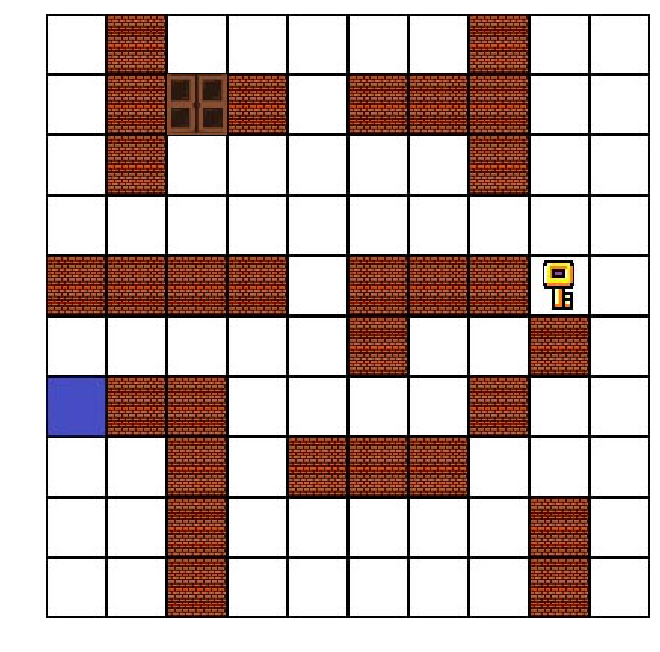

In [81]:
def generateResultMaze(weight):
    myMaze = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    myMaze.fillna(EMPTY, inplace=True)
    row = start_position[0][0]
    column = start_position[0][1]
    key = 0
    maze = generateTestMaze()
    epsilon = 1
    
    maxLength = rows_count*columns_count*10
    maxLength = 40
    step = 0
    
    #Put in the correct path
    while ((maze.iloc()[row][column] != DOOR) or (key!=1)):
        #Choose action A' from state S' using policy derived from Qw (e.g., epsilon-greedy and Q and w)
        action = epsilon_greedy_Qw(w, row, column, maze, key, epsilon)
        print("Row: {0:2d}, Column: {1:2d}, Action: {2:5s}, Key: {3}".format(row, column, ACTION_LIST[action], key))        
        if (action == 0):
            row = max(row - 1, 0)
        elif (action == 1):
            row = min(row + 1, rows_count-1)
        elif (action == 2):
            column = max(column - 1, 0)
        else:
            column = min(column + 1, columns_count-1)
            
        if (maze.iloc()[row][column] == KEY):
            key+=1
            maze.iloc()[row][column] = EMPTY
            
        myMaze.iloc()[row][column] = PATH
        step = step + 1
        
        if (step==maxLength):
            print("Failed to find the exit after walk for {} times".format(step))
            break
    
    print("Total steps took: {}".format(step))
    #Put in the wall
    for i in range(rows_count):
        for j in range (columns_count):
            if (maze.iloc()[i][j] == WALL):
                myMaze.iloc()[i][j] = WALL                
    return myMaze
showMaze(array)

Row:  6, Column:  0, Action: UP   , Key: 0
Row:  5, Column:  0, Action: RIGHT, Key: 0
Row:  5, Column:  1, Action: RIGHT, Key: 0
Row:  5, Column:  2, Action: RIGHT, Key: 0
Row:  5, Column:  3, Action: RIGHT, Key: 0
Row:  5, Column:  4, Action: UP   , Key: 0
Row:  4, Column:  4, Action: UP   , Key: 0
Row:  3, Column:  4, Action: RIGHT, Key: 0
Row:  3, Column:  5, Action: RIGHT, Key: 0
Row:  3, Column:  6, Action: RIGHT, Key: 0
Row:  3, Column:  7, Action: RIGHT, Key: 0
Row:  3, Column:  8, Action: DOWN , Key: 0
Row:  4, Column:  8, Action: UP   , Key: 1
Row:  3, Column:  8, Action: LEFT , Key: 1
Row:  3, Column:  7, Action: LEFT , Key: 1
Row:  3, Column:  6, Action: UP   , Key: 1
Row:  2, Column:  6, Action: LEFT , Key: 1
Row:  2, Column:  5, Action: LEFT , Key: 1
Row:  2, Column:  4, Action: LEFT , Key: 1
Row:  2, Column:  3, Action: LEFT , Key: 1
Row:  2, Column:  2, Action: UP   , Key: 1
Total steps take: 21
(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

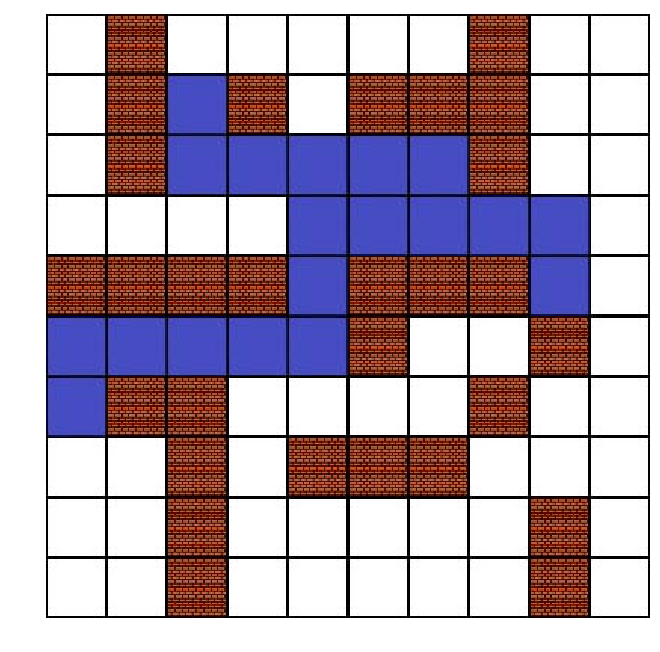

In [82]:
resultMaze = generateResultMaze(w)
resultArray = makeImageArray(start_position, resultMaze)
showMaze(resultArray)